In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.signal import find_peaks
import yfinance as yf



In [26]:

def load_data(symbol, start_date=None):

    if symbol == 'BTC-USD':
        historical_data_btc = pd.read_csv('historical_btc.csv')
        historical_data_btc['date'] = pd.to_datetime(historical_data_btc['date'])
        last_date = historical_data_btc['date'].max()
        new_data_btc = yf.download(symbol, start=start_date) if start_date else yf.download(symbol, start='1970-01-01')
        new_data_btc = new_data_btc.reset_index()
        new_data_btc = new_data_btc[['Date', 'Close']]
        new_data_btc.columns = ['date', 'btc_price']
        full_data = pd.concat([historical_data_btc, new_data_btc], axis=0)
        full_data = full_data.sort_values('date')
        full_data = full_data[full_data['date'] >= start_date] if start_date else full_data
        full_data['date'] = pd.to_datetime(full_data['date'])
        # we remove dates before start_date

        full_data = full_data.reset_index(drop=False)
        max_date = full_data['date'].max()
        print('Max date loaded:', max_date)
    else:
        new_data_btc = yf.download(symbol, start=start_date)
        new_data_btc = new_data_btc.reset_index()
        new_data_btc = new_data_btc[['Date', 'Close']]
        new_data_btc.columns = ['date', 'btc_price']
        full_data = new_data_btc
        full_data = full_data.sort_values('date')
        full_data = full_data.reset_index(drop=False)
        full_data['date'] = pd.to_datetime(full_data['date'])
        max_date = full_data['date'].max()
        print('Min date loaded:', full_data['date'].min())
        print('Max date loaded:', max_date)

    if symbol == 'SPY':
        full_data['btc_price'] = full_data['btc_price'] * 10   

    return full_data



In [27]:
def get_peaks(full_data, d_days, threshold, d_days2, min_date=None):
    full_data = full_data[['date', 'btc_price']].copy()
    full_data.reset_index(drop=True, inplace=True)
    # print('Getting peaks')

    # Find initial peaks with a specified distance
    peaks, _ = find_peaks(full_data['btc_price'], distance=d_days)
    
    # First pass to identify initial peaks
    clean_peaks = []
    btc_prices = full_data['btc_price'].values
    
    for peak in peaks:
        if not any(btc_prices[peak] < btc_prices[past_peak] for past_peak in clean_peaks):
            if peak + 1 < len(btc_prices):
                right_side = btc_prices[peak + 1:peak + 1 + d_days2]
                if len(right_side) > 0 and (right_side < btc_prices[peak] * (1 - threshold)).any():
                    clean_peaks.append(peak)

    clean_peaks = np.array(clean_peaks)
    
    # Enforce one peak per d_days using a backwards window
    final_peaks = []
    if len(clean_peaks) > 0:
        final_peaks.append(clean_peaks[0])
        for i in range(1, len(clean_peaks)):
            if clean_peaks[i] - final_peaks[-1] >= d_days:
                final_peaks.append(clean_peaks[i])
            elif btc_prices[clean_peaks[i]] > btc_prices[final_peaks[-1]]:
                final_peaks[-1] = clean_peaks[i]

    final_peaks = np.array(final_peaks)
    verified_peaks = final_peaks

    clean_peaks_after_year = verified_peaks

    if min_date:
        # if min_date < full_data['date'].min():
        # we convert min_date to datetime
        min_date = pd.to_datetime(min_date)
        min_date_index = full_data[full_data['date'] >= min_date].index[0]
        clean_peaks_after_year = clean_peaks_after_year[clean_peaks_after_year >= min_date_index]
    
    return peaks, clean_peaks_after_year

In [28]:



def get_troughs(full_data, d_days, threshold, min_date):
    full_data = full_data[['date', 'btc_price']].copy()
    full_data.reset_index(drop=True, inplace=True)
    troughs, _ = find_peaks(-full_data['btc_price'], distance=d_days)
    
    # print('Troughs:', troughs   )
    # print('Full data:', full_data)
    clean_troughs = []
    if len(troughs) > 0:
        for i, trough in enumerate(troughs):
            if not any(full_data['btc_price'][trough] > full_data['btc_price'][future_trough] for future_trough in troughs[i:]):
                clean_troughs.append(trough)

    clean_troughs = np.array(clean_troughs)
    # Enforce one peak per d_days using a backwards window
    final_troughs = []
    if len(clean_troughs) > 0:
        final_troughs.append(clean_troughs[0])
        for i in range(1, len(clean_troughs)):
            if clean_troughs[i] - final_troughs[-1] >= d_days:
                final_troughs.append(clean_troughs[i])
            elif full_data['btc_price'][clean_troughs[i]] > full_data['btc_price'][final_troughs[-1]]:
                final_troughs[-1] = clean_troughs[i]
    
    final_troughs = np.array(final_troughs)

    clean_troughs_after_year = final_troughs


    clean_troughs_after_year = clean_troughs_after_year[:-1]

    if min_date:
        min_date = pd.to_datetime(min_date)
        min_date_index = full_data[full_data['date'] >= min_date].index[0]
        clean_troughs_after_year = clean_troughs_after_year[clean_troughs_after_year >= min_date_index]


    return troughs, clean_troughs_after_year


In [66]:
def get_frame_plot(full_data, clean_peaks, clean_troughs, peak_model, trough_model, average_model_prices,min_x, max_x, min_y, max_y, symbol, peak_model_params, trough_model_params, average_model_params, peak_r2, trough_r2, current_date=None, alpha=1, transparency = False, ax=None):
    # fig, axs = plt.subplots(1, 3, figsize=(14, 7.3))

    if ax is None:
        fig, axs = plt.subplots(1, 3, figsize=(14, 7.25))
    else:
        fig, axs = plt.gcf(), ax

    if transparency == False:
        for ax_i in axs:
            ax_i.clear()

    if min_x is not None:
        min_x = pd.to_datetime(min_x)
        if min_x < full_data['date'].min():
            min_x = full_data['date'].min()

    if max_x is not None:
        max_x = pd.to_datetime(max_x)
        if max_x > full_data['date'].max():
            max_x = full_data['date'].max()


    axs[0].plot(full_data['date'], full_data['btc_price'], label='BTC Price', color='blue')
    axs[0].scatter(full_data['date'][clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks', alpha=alpha)
    axs[0].scatter(full_data['date'][clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs', alpha=alpha)
    axs[0].plot(full_data['date'], peak_model, color='red', label='Model Peaks', alpha=alpha)
    axs[0].plot(full_data['date'], trough_model, color='green', label='Model Troughs', alpha=alpha)
    axs[0].plot(full_data['date'], average_model_prices, color='orange', label='Model Average', alpha=alpha)
    axs[0].set_title(f'{symbol} price')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    # axs[0].legend()
    # full_data['date'].min() if min_x is None else pd.datatime(min_x)
    axs[0].set_xlim(full_data['date'].min() if min_x is None else min_x, full_data['date'].max() if max_x is None else max_x)
    # axs[0].set_ylim(full_data['btc_price'].min(), full_data['btc_price'].max())
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].yaxis.set_major_formatter('${:,.0f}'.format)
    # axs[0].legend()
    axs[0].set_ylim([0, max_y])  # Set max for the first axis
    # axs[0].set_xlim([min_x, full_data['date'].max()])  # Set min for the first axis

    # Log scale
    axs[1].plot(full_data['date'], full_data['btc_price'], label='BTC Price', color='blue')
    axs[1].scatter(full_data['date'][clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks', alpha=alpha)
    axs[1].scatter(full_data['date'][clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs', alpha=alpha)
    axs[1].plot(full_data['date'], peak_model, color='red', label='Model Peaks', alpha=alpha)
    axs[1].plot(full_data['date'], trough_model, color='green', label='Model Troughs', alpha=alpha)
    axs[1].plot(full_data['date'], average_model_prices, color='orange', label='Model Average', alpha=alpha)
    axs[1].set_xlim(full_data['date'].min() if min_x is None else min_x, full_data['date'].max() if max_x is None else max_x)
    # axs[1].set_ylim(full_data['btc_price'].min(), full_data['btc_price'].max())
    axs[1].set_title(f'{symbol} price (log)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_yscale('log')
    axs[1].set_ylim([min_y, max_y])  # Set log y range

    # # Log-log scale
    axs[2].plot(full_data.index, full_data['btc_price'], label='BTC Price', color='blue')
    if len(clean_peaks) > 0:
        axs[2].scatter(full_data.index[clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks', alpha=alpha)
    if len(clean_troughs) > 0:
        axs[2].scatter(full_data.index[clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs', alpha=alpha)
    axs[2].plot(full_data.index, peak_model, color='red', label='Model Peaks', alpha=alpha)
    axs[2].plot(full_data.index, trough_model, color='green', label='Model Troughs', alpha=alpha)
    axs[2].plot(full_data.index, average_model_prices, color='orange', label='Model Average', alpha=alpha)
    axs[2].set_title(f'{symbol} price (log-log)')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Price')
    axs[2].set_yscale('log')
    axs[2].set_xscale('log')
    if max_x is None:
        max_index = len(full_data) - 1
    else:
        max_index = full_data[full_data['date'] <= max_x].index[-1]
    if max_index < 1000:
        axs[2].set_xticks([1, 10, 100, 1000])
    else:
        axs[2].set_xticks([1, 10, 100, 1000, max_index])
    axs[2].set_xticklabels([full_data['date'][1].year, full_data['date'][10].year, full_data['date'][100].year, full_data['date'][1000].year, full_data['date'][max_index].year])
    axs[2].yaxis.set_major_formatter('${:,.0f}'.format)
    axs[2].set_ylim([min_y, max_y])
    if min_x is not None:
        # we look for the index of the min_x date
        min_x_index = full_data[full_data['date'] >= min_x].index[0]
        axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


    subtitle = f"{symbol} Current Date: {current_date.strftime('%Y-%m-%d') if current_date else 'N/A'}\n"
    if peak_model_params is not None:
        subtitle += f"Peak Model Params: a={peak_model_params[0]:.4f}, b={peak_model_params[1]:.4f}, R²={peak_r2:.4f}\n"
    else:
        subtitle += "Peak Model Params: waiting for peaks\n"
    if trough_model_params is not None:
        subtitle += f"Trough Model Params: a={trough_model_params[0]:.4f}, b={trough_model_params[1]:.4f}, R²={trough_r2:.4f}\n"
    else:
        subtitle += "Trough Model Params: waiting for troughs\n"

    if average_model_params is not None:
        subtitle += f"Mid Model Params: a={average_model_params[0]:.4f}, b={average_model_params[1]:.4f}\n"
    else:
        subtitle += "Mid Model Params: waiting for peaks and troughs\n"
    
    fig.suptitle(subtitle)

    plt.subplots_adjust(top=0.8, wspace=alpha)    

    return fig, axs


In [30]:
def get_power_law_model(full_data, samples, text):
    historical_index = full_data.index
    if len(samples) < 2:
        model_price = [None] * len(historical_index)
        return model_price, None, None
    
    
    samples_index = full_data.index[samples]
    samples_price = full_data['btc_price'][samples]
    log_samples_index = np.log(samples_index)
    log_samples_price = np.log(samples_price)

    # Fit a linear model to the log-log data

    
    model_params = np.polyfit(log_samples_index, log_samples_price, 1)
    model_price = np.exp(model_params[1]) * historical_index**model_params[0]
    model_price_samples = np.exp(model_params[1]) * samples_index**model_params[0]

    # Calculate R^2
    residuals = samples_price - model_price_samples
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((samples_price - np.mean(samples_price))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f'{text} R2 = ', r_squared)

    return model_price, model_params, r_squared



WE TRY TO EXTEND MODEL INTO THE FUTURE

In [31]:
def extend_data(full_data,final_year_model_prediction = 2040):
    final_date = pd.to_datetime(f'01-01-{final_year_model_prediction}')
    # we extend full_data to finish at final_date, creating a new row for each day. BTC price is NaN for these rows
    full_data = full_data.set_index('date')
    full_data = full_data.reindex(pd.date_range(full_data.index.min(), final_date, freq='D'))
    # we convert the index to a column
    full_data = full_data.reset_index()
    full_data.columns = ['date', 'btc_price']
    # full_data = full_data.reset_index(drop=False, inplace=True)
    return full_data

In [32]:
historical_data = load_data('BTC-USD')

c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

Max date loaded: 2024-06-01 00:00:00


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Max date loaded: 2024-06-01 00:00:00
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513


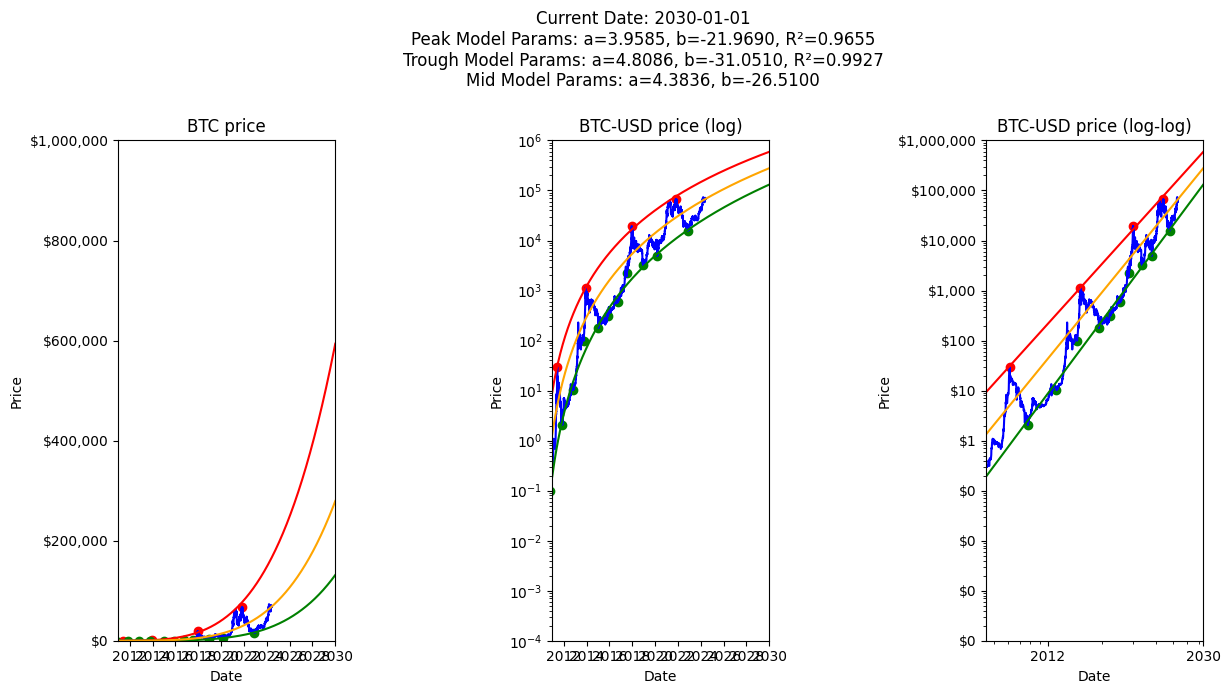

In [45]:
symbol = 'BTC-USD'
historical_data = load_data(symbol)
min_date_model = '2010-01-01'
final_year_model_prediction = 2030
d_days = 300
d_days2 = 300
threshold = 0.45
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e-4
max_y = 1e6
min_x = '2011-01-01'
max_x = '2030-01-01'

current_date = full_data['date'].max()
   

peaks, clean_peaks = get_peaks(full_data, d_days, threshold, d_days2, min_date_model)
troughs, clean_troughs = get_troughs(full_data, d_days, threshold, min_date_model)
peak_model_prices, peak_model_params, peak_r2 = get_power_law_model(full_data, clean_peaks, 'Peak Model')
trough_model_prices, trough_model_params, trough_r2 = get_power_law_model(full_data, clean_troughs, 'Trough Model')
average_model_params = (peak_model_params + trough_model_params) / 2
average_model_prices = np.exp(average_model_params[1]) * full_data.index**average_model_params[0]

fig, ax = get_frame_plot(full_data, clean_peaks, clean_troughs, peak_model_prices, trough_model_prices, average_model_prices, min_x, max_x, min_y, max_y, symbol, peak_model_params, trough_model_params, average_model_params, peak_r2, trough_r2, current_date)
plt.show()


In [46]:
def animate(i, full_data, d_days, threshold, d_days2,min_x, max_x,min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency):
    current_date = pd.Timestamp(f'{min_year_ani}-01-01') + pd.DateOffset(months=i)
    temp_data = full_data.copy()
    # print(temp_data['date'])
    # temp_data['btc_price'][temp_data['date'] > current_date] = np.nan
    temp_data.loc[temp_data['date'] > current_date, 'btc_price'] = np.nan
    peaks, clean_peaks = get_peaks(temp_data, d_days, threshold, d_days2, min_date_model)
    troughs, clean_troughs = get_troughs(temp_data, d_days, threshold, min_date_model)
    peak_model_prices, peak_model_params, peak_r2 = get_power_law_model(temp_data, clean_peaks, 'Peak Model')
    trough_model_prices, trough_model_params, trough_r2 = get_power_law_model(temp_data, clean_troughs, 'Trough Model')
    average_model_params = (peak_model_params + trough_model_params) / 2 if peak_model_params is not None and trough_model_params is not None else None
    average_model_prices = np.exp(average_model_params[1]) * full_data.index**average_model_params[0] if average_model_params is not None else [None] * len(full_data)

    axs = get_frame_plot(temp_data, clean_peaks, clean_troughs, peak_model_prices, trough_model_prices, average_model_prices, min_x, max_x, min_y, max_y, symbol, peak_model_params, trough_model_params, average_model_params, peak_r2, trough_r2, current_date, alpha, transparency, ax=axs)
    return axs

c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Max date loaded: 2024-06-01 00:00:00
Trough Model R2 =  1.0
Peak Model R2 =  1.0
Trough Model R2 =  0.9998170619185069
Peak Model R2 =  1.0
Trough Model R2 =  0.7669522608279135
Peak Model R2 =  1.0
Trough Model R2 =  0.8804005934215233
Peak Model R2 =  1.0
Trough Model R2 =  0.9228110110153591
Peak Model R2 =  1.0
Trough Model R2 =  0.9698344270913707
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.7857522156526497
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9201565226228238
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9201565226228238
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9512750269946085
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.9512750269946085
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0

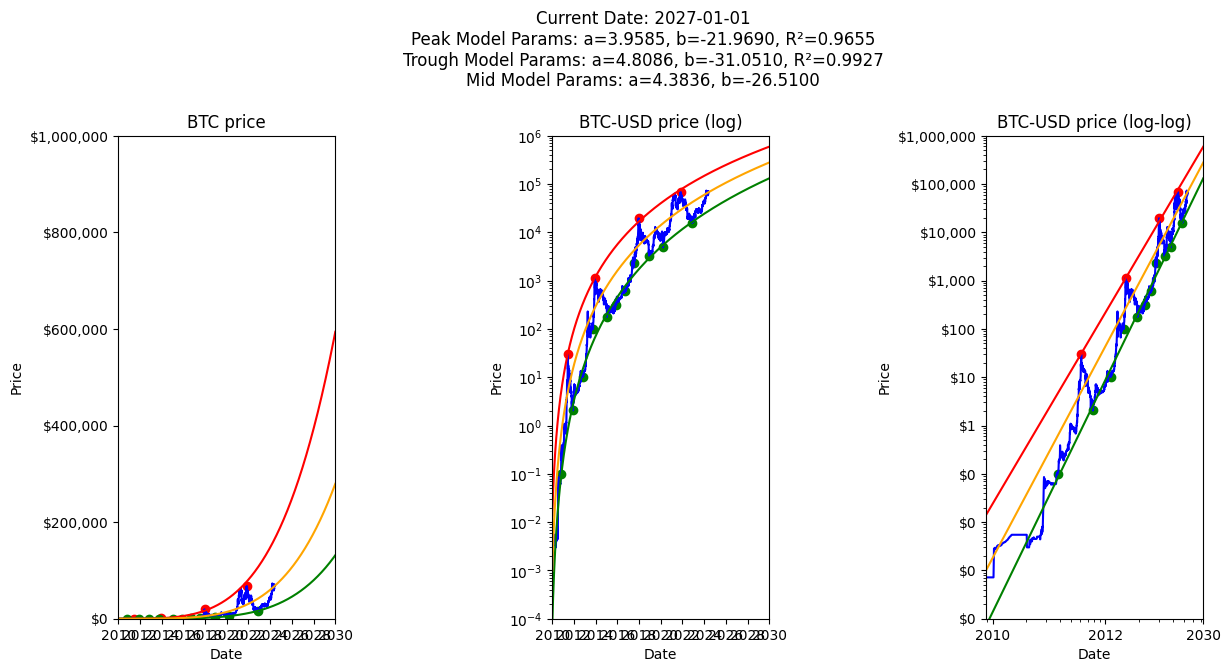

In [47]:
symbol = 'BTC-USD'
historical_data = load_data(symbol)
min_date_model = '2010-01-01'
final_year_model_prediction = 2040
d_days = 300
d_days2 = 300
threshold = 0.45
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data
min_year_ani = 2012
max_year_ani = 2027
months_step = 12

min_y = 1e-4
max_y = 1e6
min_x = '2010-01-01'
max_x = '2030-01-01'

transparency = False
alpha = 1

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_btc1.gif', writer=PillowWriter(fps=1))

plt.show()


TRANSPARENCY TRAIL

c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Max date loaded: 2024-06-01 00:00:00
Trough Model R2 =  1.0
Peak Model R2 =  1.0
Trough Model R2 =  0.9998170619185069
Peak Model R2 =  1.0
Trough Model R2 =  0.7669522608279135
Peak Model R2 =  1.0
Trough Model R2 =  0.8804005934215233
Peak Model R2 =  1.0
Trough Model R2 =  0.9228110110153591
Peak Model R2 =  1.0
Trough Model R2 =  0.9698344270913707
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.7857522156526497
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9201565226228238
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9201565226228238
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9512750269946085
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.9512750269946085
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0

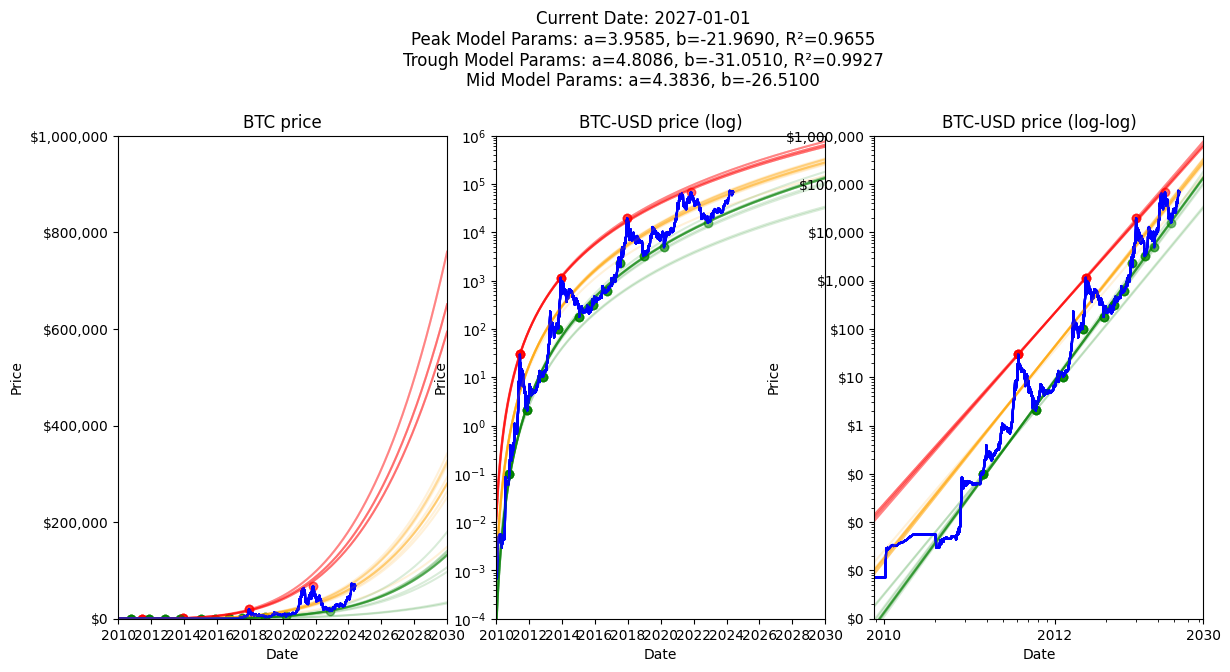

In [52]:
symbol = 'BTC-USD'
historical_data = load_data(symbol)
min_date_model = '2010-01-01'
final_year_model_prediction = 2040
d_days = 300
d_days2 = 300
threshold = 0.45
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data
min_year_ani = 2012
max_year_ani = 2027
months_step = 12

min_y = 1e-4
max_y = 1e6
min_x = '2010-01-01'
max_x = '2030-01-01'

transparency = True
alpha = 0.15

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_btc1t.gif', writer=PillowWriter(fps=1))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Min date loaded: 2017-11-09 00:00:00
Max date loaded: 2024-06-01 00:00:00
Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.572692762015781


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.572692762015781


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9085700099380473


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9516300767621664


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9516300767621664


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9516300767621664


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9516300767621664


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9516300767621664


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9516300767621664


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


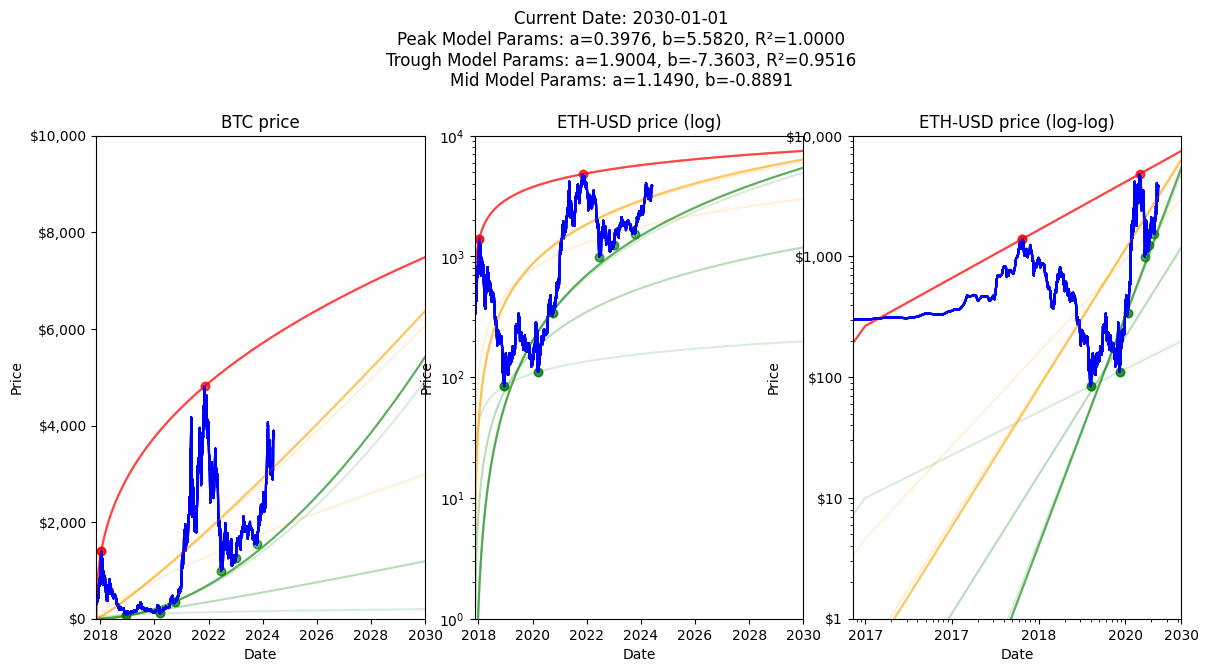

In [55]:
symbol = 'ETH-USD'
historical_data = load_data(symbol)
min_date_model = '2017-01-01'
final_year_model_prediction = 2040
d_days = 200
d_days2 = 200
threshold = 0.55
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data
min_year_ani = 2020
max_year_ani = 2030
months_step = 12


min_y = 1e0
max_y = 1e4
min_x = '2015-01-01'
max_x = '2030-01-01'

transparency = True
alpha = 0.15

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_ETH1t.gif', writer=PillowWriter(fps=1))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Min date loaded: 2014-09-17 00:00:00
Max date loaded: 2024-06-01 00:00:00
Peak Model R2 =  1.0
Trough Model R2 =  0.9307072752582127
Peak Model R2 =  1.0
Trough Model R2 =  0.9307072752582127
Peak Model R2 =  -0.2879555643143752
Trough Model R2 =  0.9389703652211373


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  -0.2879555643143752
Trough Model R2 =  0.9307072752582127


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  -0.2879555643143752
Trough Model R2 =  0.9575211157423335


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  -0.2879555643143752
Trough Model R2 =  0.9781056973231549


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  -0.2879555643143752
Trough Model R2 =  0.9781056973231549


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  -0.2879555643143752
Trough Model R2 =  0.9781056973231549


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2856733050.py:88: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


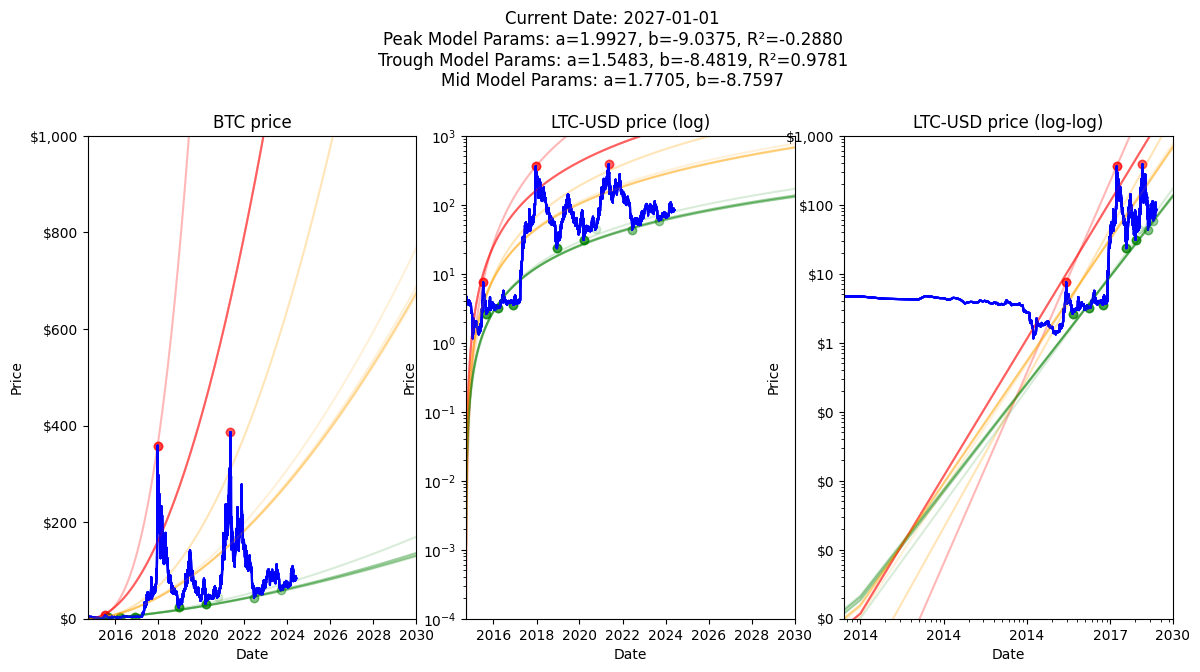

In [57]:
symbol = 'LTC-USD'
historical_data = load_data(symbol)
min_date_model = '2015-06-01'
final_year_model_prediction = 2040
d_days = 200
d_days2 = 200
threshold = 0.55
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data
min_year_ani = 2021
max_year_ani = 2027
months_step = 12

min_y = 1e-4
max_y = 1e3
min_x = '2010-01-01'
max_x = '2030-01-01'

transparency = True
alpha = 0.15

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_LTC1t.gif', writer=PillowWriter(fps=1))

plt.show()

c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Min date loaded: 2020-04-10 00:00:00
Max date loaded: 2024-06-01 00:00:00
Peak Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9644058338798398


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9644058338798398


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9644058338798398


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\1526285190.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


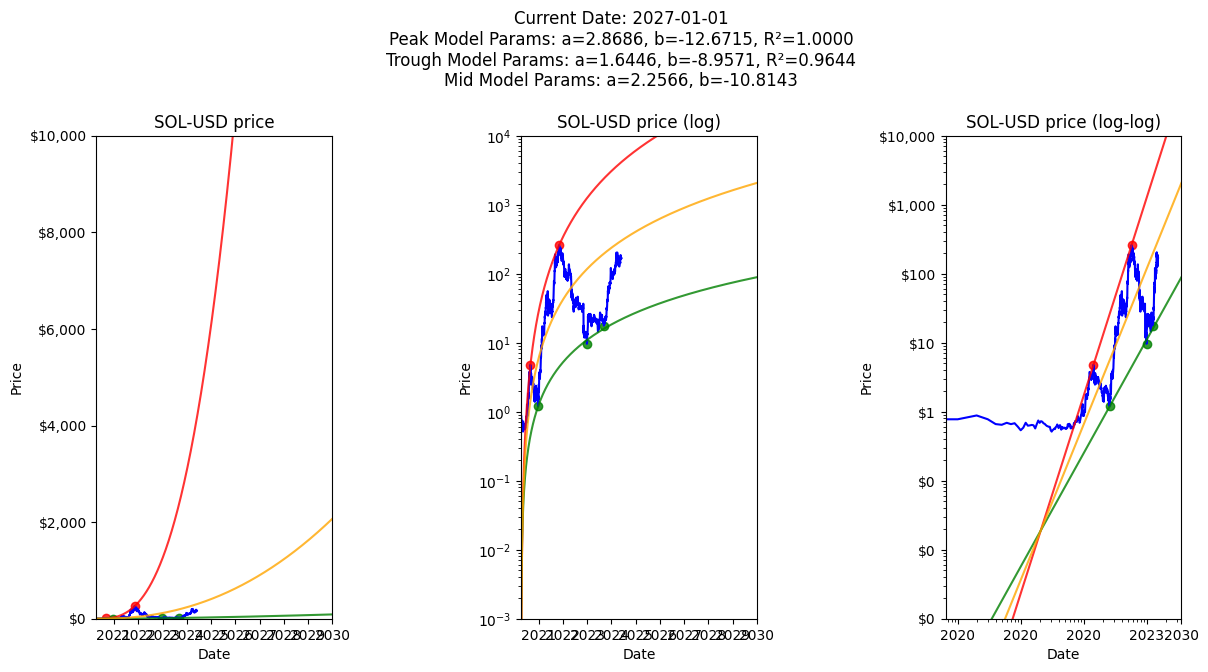

In [60]:
symbol = 'SOL-USD'
historical_data = load_data(symbol)
min_date_model = '2020-06-01'
final_year_model_prediction = 2040
d_days = 200
d_days2 = 300
threshold = 0.40
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data
min_year_ani = 2021
max_year_ani = 2027
months_step = 12

min_y = 1e-3
max_y = 1e4
min_x = '2015-01-01'
max_x = '2030-01-01'

transparency = False
alpha = 0.8

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_SOL1.gif', writer=PillowWriter(fps=1))

plt.show()

c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Min date loaded: 1999-01-22 00:00:00
Max date loaded: 2024-05-31 00:00:00
Trough Model R2 =  0.8408111496615553
Trough Model R2 =  0.8408111496615553
Trough Model R2 =  0.8408111496615553
Trough Model R2 =  0.8408111496615553
Trough Model R2 =  0.684234109519831
Trough Model R2 =  0.684234109519831
Trough Model R2 =  0.684234109519831
Peak Model R2 =  1.0
Trough Model R2 =  0.684234109519831
Peak Model R2 =  1.0
Trough Model R2 =  0.684234109519831
Peak Model R2 =  1.0
Trough Model R2 =  0.8408111496615553
Peak Model R2 =  1.0
Trough Model R2 =  0.8408111496615553
Peak Model R2 =  1.0
Trough Model R2 =  0.8408111496615553
Peak Model R2 =  1.0
Trough Model R2 =  0.9185758780390004
Peak Model R2 =  1.0
Trough Model R2 =  0.9185758780390004
Peak Model R2 =  1.0
Trough Model R2 =  0.9185758780390004
Peak Model R2 =  1.0
Trough Model R2 =  0.9185758780390004
Peak Model R2 =  1.0
Trough Model R2 =  0.9185758780390004
Peak Model R2 =  1.0
Trough Model R2 =  0.9185758780390004
Peak Model R2 = 

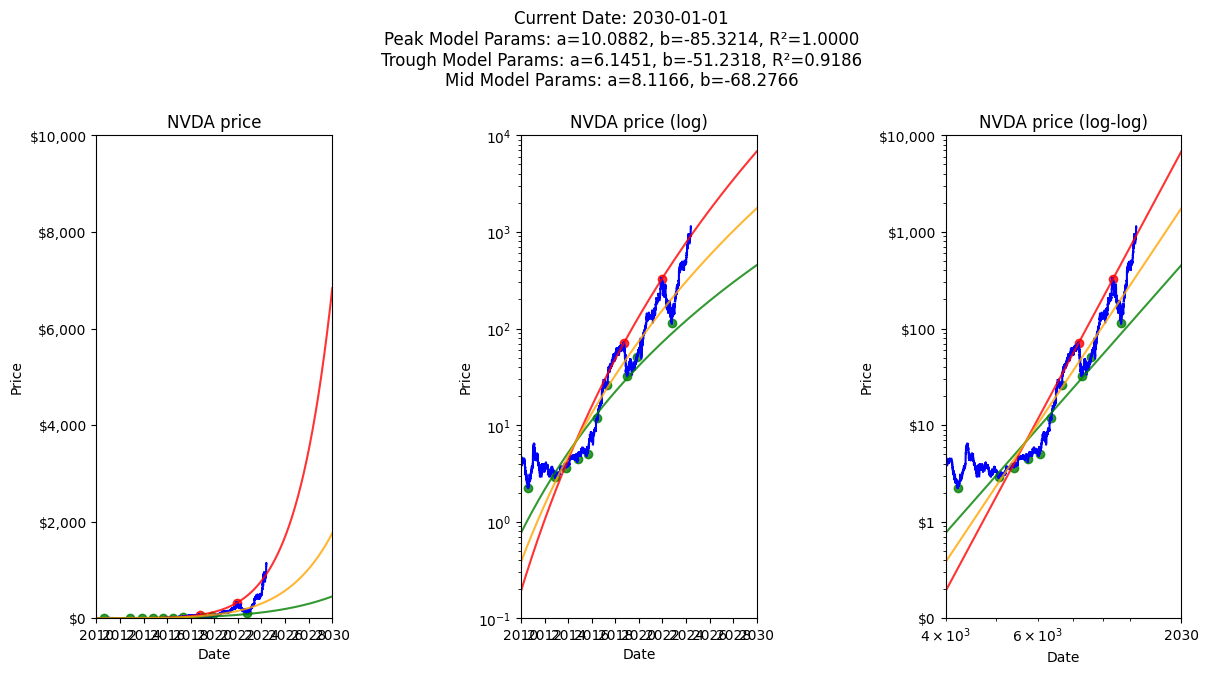

In [65]:
symbol = 'NVDA'
historical_data = load_data(symbol)
min_date_model = '2010-01-01'
final_year_model_prediction = 2040
d_days = 300
d_days2 = 300
threshold = 0.40
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data
min_year_ani = 2021
max_year_ani = 2030
months_step = 3

min_y = 1e-1
max_y = 1e4
min_x = '2010-01-01'
max_x = '2030-01-01'

transparency = False
alpha = 0.8

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_NVDA1.gif', writer=PillowWriter(fps=2))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Min date loaded: 1993-01-29 00:00:00
Max date loaded: 2024-05-31 00:00:00
Trough Model R2 =  1.0
Trough Model R2 =  0.9422234330772116
Peak Model R2 =  1.0
Peak Model R2 =  1.0
Peak Model R2 =  1.0
Trough Model R2 =  0.9100430085778782
Peak Model R2 =  1.0
Trough Model R2 =  0.985190231002063
Peak Model R2 =  1.0
Trough Model R2 =  0.9183544172482055
Peak Model R2 =  0.7893202749005037
Trough Model R2 =  0.9718666685706321
Peak Model R2 =  0.8504625340593304
Trough Model R2 =  0.9583981826485659
Peak Model R2 =  0.75027397848297
Trough Model R2 =  0.9132297168236123
Peak Model R2 =  0.75027397848297
Trough Model R2 =  0.9593512860952974
Peak Model R2 =  0.75027397848297
Trough Model R2 =  0.9593512860952974
Peak Model R2 =  0.75027397848297
Trough Model R2 =  0.9593512860952974


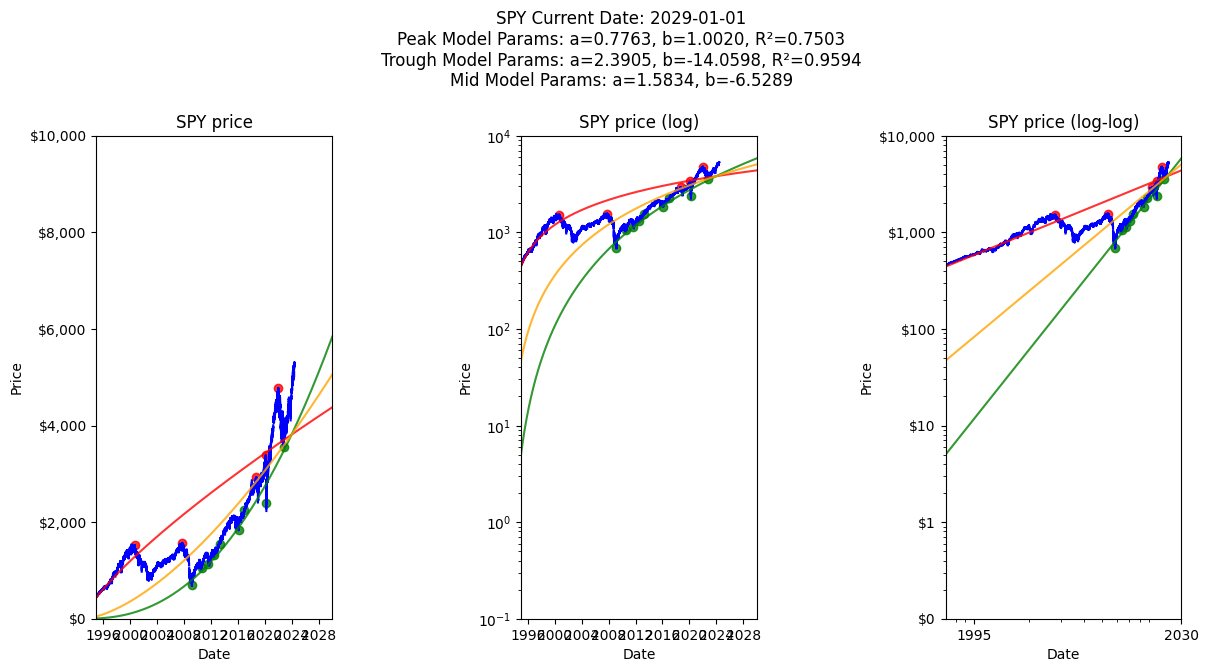

In [79]:
symbol = 'SPY'
historical_data = load_data(symbol)

final_year_model_prediction = 2040
d_days = 300
d_days2 = 300
threshold = 0.2
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e-1
max_y = 1e4

min_date_model = '2000-01-01'
min_x = '1995-01-01'
max_x = '2030-01-01'
min_year_ani = 1995
max_year_ani = 2030

months_step = 24

transparency = False
alpha = 0.8

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_SPY1.gif', writer=PillowWriter(fps=1))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Min date loaded: 2010-06-29 00:00:00
Max date loaded: 2024-05-31 00:00:00


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9039636383687537


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.8191443904550566


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.6712464593191372


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  0.3961280712898443
Trough Model R2 =  0.37015661536569733


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  0.6277793458407057
Trough Model R2 =  0.5685575168040848


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  0.6277793458407057
Trough Model R2 =  0.5685575168040848


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  0.6277793458407057
Trough Model R2 =  0.5685575168040848


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  0.6277793458407057
Trough Model R2 =  0.5685575168040848


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  0.6277793458407057
Trough Model R2 =  0.5685575168040848


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  0.6277793458407057
Trough Model R2 =  0.5685575168040848


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


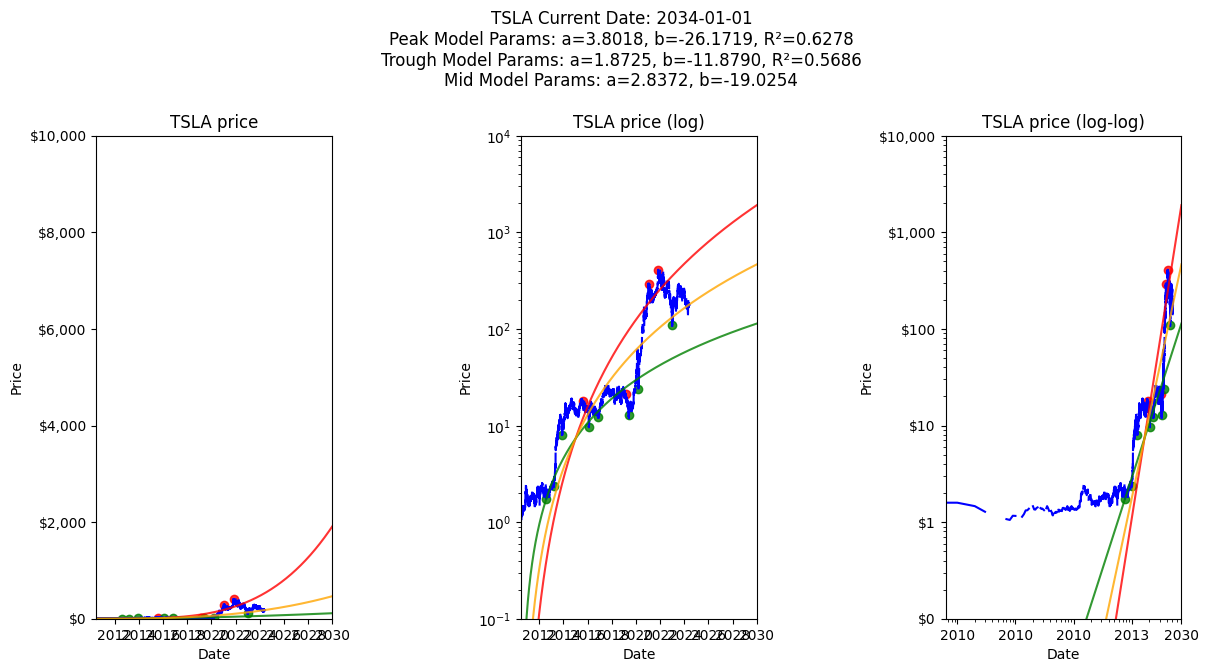

In [77]:
symbol = 'TSLA'
historical_data = load_data(symbol)

final_year_model_prediction = 2040
d_days = 200
d_days2 = 200
threshold = 0.35
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e-1
max_y = 1e4

min_date_model = '2012-01-01'
min_x = '1995-01-01'
max_x = '2030-01-01'
min_year_ani = 2010
max_year_ani = 2034

months_step = 24

transparency = False
alpha = 0.8

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_TSLA1.gif', writer=PillowWriter(fps=1))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


Min date loaded: 1986-03-13 00:00:00
Max date loaded: 2024-05-31 00:00:00
Peak Model R2 =  1.0
Trough Model R2 =  1.0
Peak Model R2 =  1.0
Trough Model R2 =  1.0
Peak Model R2 =  1.0
Trough Model R2 =  0.8211112558293887
Peak Model R2 =  1.0
Trough Model R2 =  0.8883436736913964
Peak Model R2 =  1.0
Trough Model R2 =  0.8373233838585252
Peak Model R2 =  1.0
Trough Model R2 =  0.7474205566891021
Peak Model R2 =  0.8518949510739807
Trough Model R2 =  0.6705308990275214
Peak Model R2 =  1.0
Trough Model R2 =  0.5475531021638456
Peak Model R2 =  0.9851411693913777
Trough Model R2 =  0.49711389721715893
Peak Model R2 =  0.9851411693913777
Trough Model R2 =  0.49711389721715893
Peak Model R2 =  0.9851411693913777
Trough Model R2 =  0.49711389721715893
Peak Model R2 =  0.9851411693913777
Trough Model R2 =  0.49711389721715893
Peak Model R2 =  0.9851411693913777
Trough Model R2 =  0.49711389721715893
Peak Model R2 =  0.9851411693913777
Trough Model R2 =  0.49711389721715893


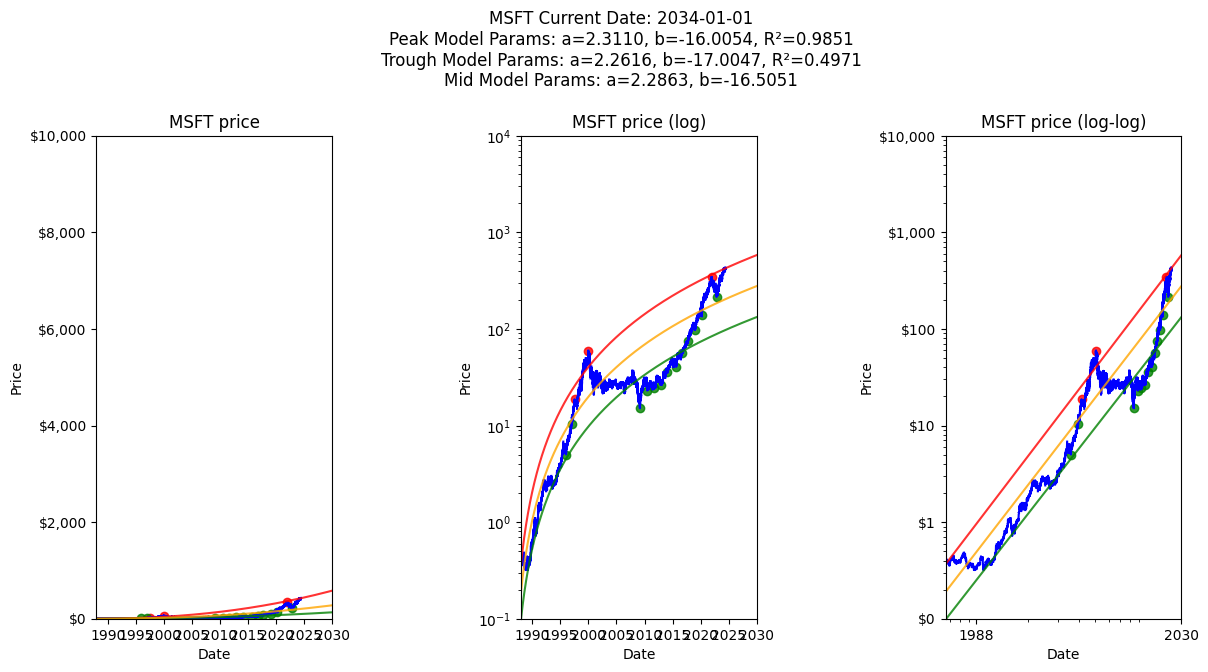

In [87]:
symbol = 'MSFT'
historical_data = load_data(symbol)

final_year_model_prediction = 2040
d_days = 365
d_days2 = 365
threshold = 0.15
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e-1
max_y = 1e4

min_date_model = '1995-01-01'
min_x = '1988-01-01'
max_x = '2030-01-01'
min_year_ani = 2010
max_year_ani = 2034

months_step = 24

transparency = False
alpha = 0.8

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_MSFT1.gif', writer=PillowWriter(fps=1))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Min date loaded: 2004-08-19 00:00:00
Max date loaded: 2024-05-31 00:00:00
Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9650846703506876


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9697309202630005


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


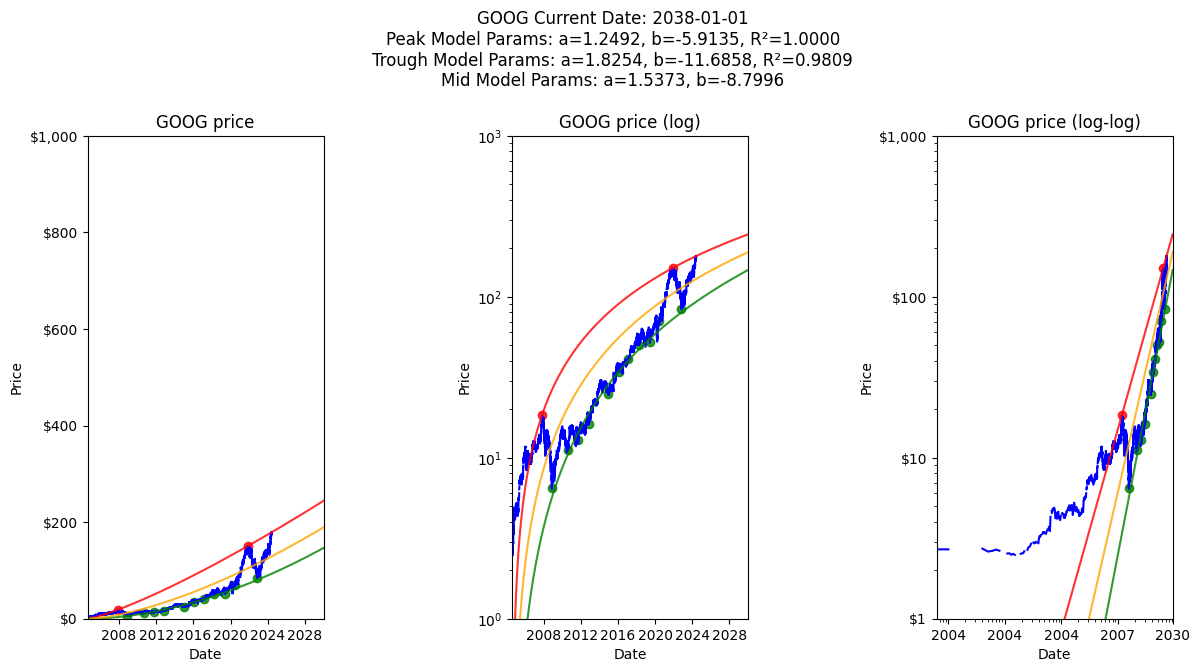

In [93]:
symbol = 'GOOG'
historical_data = load_data(symbol)

final_year_model_prediction = 2040
d_days = 365
d_days2 = 365
threshold = 0.35
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e0
max_y = 1e3

min_date_model = '2005-01-01'
min_x = '1988-01-01'
max_x = '2030-01-01'
min_year_ani = 2010
max_year_ani = 2038

months_step = 24

transparency = False
alpha = 0.8

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_GOOG1.gif', writer=PillowWriter(fps=1))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Min date loaded: 2004-08-19 00:00:00
Max date loaded: 2024-05-31 00:00:00


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set 

Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  1.0


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9793822813012893


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9793822813012893


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9793822813012893


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9793822813012893


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9793822813012893


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9908822763724179


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9881603094782451


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9881603094782451


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9881603094782451


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9881603094782451


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9650846703506876


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9650846703506876


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9650846703506876


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9650846703506876


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9682160201680289


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9682160201680289


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9682160201680289


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9682160201680289


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9697309202630005


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9697309202630005


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9697309202630005


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9697309202630005


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9697309202630005


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9785354301141541


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9785354301141541


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9785354301141541


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9785354301141541


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9692527670758972


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Peak Model R2 =  1.0
Trough Model R2 =  0.9808617233498402


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


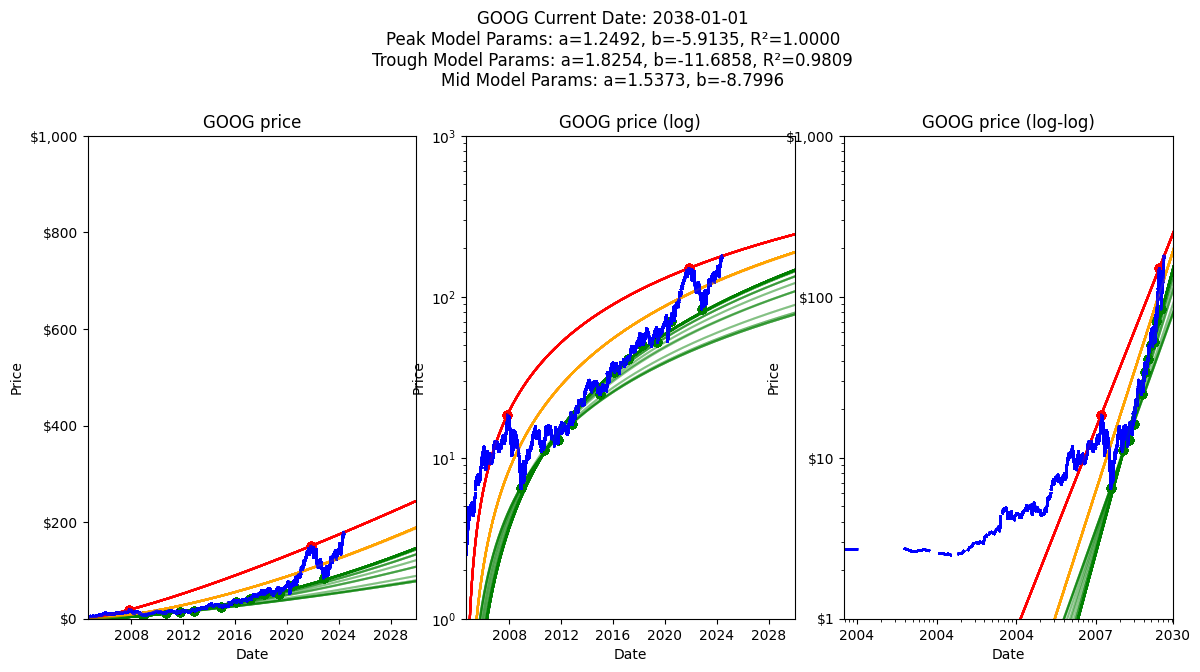

In [ ]:
symbol = 'GOOG'
historical_data = load_data(symbol)

final_year_model_prediction = 2040
d_days = 365
d_days2 = 365
threshold = 0.35
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e0
max_y = 1e3

min_date_model = '2005-01-01'
min_x = '1988-01-01'
max_x = '2030-01-01'
min_year_ani = 2010
max_year_ani = 2038

months_step = 3

transparency = True
alpha = 0.15

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_GOOG1t.gif', writer=PillowWriter(fps=3))

plt.show()


In [96]:
symbol = 'BTC'
historical_data = load_data(symbol)

final_year_model_prediction = 2040
d_days = 365
d_days2 = 365
threshold = 0.35
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e0
max_y = 1e3

min_date_model = '2010-01-01'
min_x = '1988-01-01'
max_x = '2030-01-01'
min_year_ani = 2010
max_year_ani = 2038

months_step = 3

transparency = True
alpha = 0.15

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_x, max_x, min_y, max_y, symbol, min_date_model, min_year_ani,axs, alpha, transparency)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_BTC2tt.gif', writer=PillowWriter(fps=3))

plt.show()


c:\Github\repos\swanhunt\.conda\Lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis


Min date loaded: 2020-10-01 00:00:00
Max date loaded: 2024-05-31 00:00:00


C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[2].set_xlim([min_x_index, max_index])  # Set min for the third axis
C:\Users\jordi\AppData\Local\Temp\ipykernel_37460\2664801011.py:87: UserWarning: Attempt to set 